# Binding energy calculation

## Justification


Here is a more detailed explanation of why we decided to parameterise the equilibrium constant rather than use the Gibbs free energy equation. The purpose of this reparameterisation is to find an equilibrium constant $K_{eq}$ that matches the reality of RNA binding for a given binding energy $G$, which is calculated by physics simulators. The Gibbs free energy equation does relate energy to $K_{eq}$, but does not match experimental data well and highly underestimates the $K_{eq}$. For two interacting RNAs, their binding energy and thus likelihood of interacting may be found through a variety of RNA simulators. 

In practice, this binding energy $\Delta G$ may translate into actual binding and subsequent repression in a genetic circuit through the forward and reverse equilibrium rates of the reaction. Both of these will vary based on the RNA, so we have chosen to parameterise the RNA binding from existing data using the research paper ["Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs" (2013)](https://www.nature.com/articles/nbt.2461#Fig1). The authors tested a variety of RNAs that could bind to a GFP mRNA with varying binding energies $G$, which they calculated through the RNA simulator NUPACK (rated very similarly to the RNA simulator used here, IntaRNA). They measured the subsequent relative fluorescence as a proxy for repression efficiency and thereby mRNA abundance, or the proportion of unbound to bound RNA. The more mRNA was bound, the less mRNA was free to be read into GFP. 

Here, a sigmoid function was fit to the relative fluorescence data, for which the exact numbers have been estimated as the original data is no longer available.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('dark_background')
import diffrax as dfx
import numpy as np
import jax.numpy as jnp

Estimating the function to best fit the data as a sigmoid function.

Using the following points as guidelines:
- -3kcal $\approx$ 1 F
- -10kcal $\approx$ 0.5 F
- -22kcal $\approx$ 0.1 Fluorescence
- -37kcal $\approx$ 0.01 F

Fluorescence is at the 50% point at:  -10.0  kcal

At -3kcal:  0.9709808915561572

At -10kcal:  0.505

At -22kcal:  0.012447896925068426

At -38kcal:  0.01000135724763479


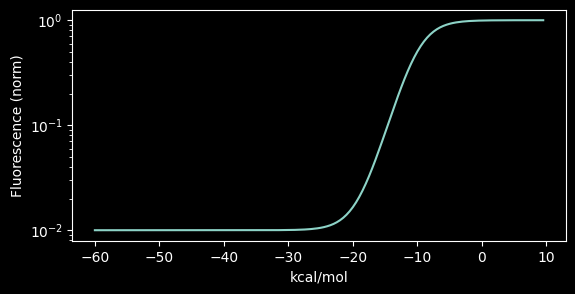

In [3]:
def cal_to_j(E_cal):
    return E_cal * 4.184


def j_to_cal(E_j):
    return E_j / 4.184


def binding_energy_sigmoid(E):
    """ The binding energy is in units of kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F


def binding_energy_sigmoid_J(E):
    """ The binding energy is in units of kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/8.368 + 5))) + 0.01
    return F


E = np.arange(-60, 10, 0.5)

plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.plot(
    E,
    binding_energy_sigmoid(E)
)
plt.xlabel('kcal/mol')
plt.ylabel('Fluorescence (norm)')
plt.yscale('log')


print('Fluorescence is at the 50% point at: ', E[np.argmax(binding_energy_sigmoid(E) >= 0.5)], ' kcal')

print('\nAt -3kcal: ', binding_energy_sigmoid(-3))
print('\nAt -10kcal: ', binding_energy_sigmoid(-10))
print('\nAt -22kcal: ', binding_energy_sigmoid(-22))
print('\nAt -38kcal: ', binding_energy_sigmoid(-37))


## Derivation of $K_{eq}$ from steady states

Because the fluorescence is actually relative fluorescence, it is convenient to use it as a measure for the relative amount of unbound RNA, so the fraction of all RNA that is unbound. 

For this, we need to derive an equation for the amount of unbound RNA and for the total amount of RNA.

We will start by looking at a case of an RNA system that has $n = 3$ different RNA species that can all bind together. We also assume in this case that the rates of binding are the same for all species and that they all start at the same quantity. This would give us the following differential equation, where $k_a$ is the forward rate, $k_d$ is the reverse rate, $x_i$ are the unbound species, and $x_{ij}$ are the bound species. 

$$ \frac{dx_1}{dt} = k_d (x_{11} + x_{12} + x_{13}) - k_a x_1 (x_1 + x_2 + x_3) $$

At $ \frac{dx_1}{dt} = 0 $:

$$ k_d (x_{11} + x_{12} + x_{13}) = k_a x_1 (x_1 + x_2 + x_3) $$

We can simplify the rates to the equilibrium constant $ K_{eq} = k_a / k_d $ and then solve for $ x_1 $. Since the interactions and starting quanitities are the same for all species, the unbound species can all be substituted for one another - same for the bound species:

$$ (x_{11} + x_{12} + x_{13}) = K x_1 (x_1 + x_2 + x_3) $$
$$ n x_{11} = K n x_1^2 $$
$$ x_{ii} = K x_i^2 $$

The total amount of RNA must be conserved, giving the following equation for the starting quantity of RNA $m_i$: 

$$ m_1 = x_1 + 2 x_{11} + x_{12} + x_{13} $$
$$ m_i = x_i + 2 x_{ii} + \Sigma{x_{ij}} $$
$$ m_i = x_i + (1 + n) x_{ii} $$

Now substituting for the bound species and applying the quadratic formula:

$$ m_i = x_i + (1 + n) (K x_i^2) $$
$$ 0 = K (1 + n) x_i^2 + x_i - m_i $$

$$ x_i = \frac{-1 + \sqrt{1 + 4 K m_i (1+n)}}{2 K (1+n)} $$

These can now be brought together to give the fraction of the unbound species $x_i$ with respect to the total RNA $r_i$.

$$ r_i = \frac{x_i}{m_i} = \frac{x_i}{x_i + (1+n) x_{ii}} = \frac{x_i}{x_i + (1+n) (K x_i^2)} $$
$$ r_i = \frac{1}{1 + K (1+n) (x_i)} $$
$$ r_i = \frac{1}{1 + K (1+n) (\frac{-1 + \sqrt{1 + 4 K m_i (1+n)}}{2 K (1+n)})} $$
$$ r_i = \frac{2}{1 + \sqrt{1 + 4 K m_i (1+n)}} $$

The derived $r_i$ is equivalent to the relative fluorescence. We can solve for K from this:

$$ r_i (1 + \sqrt{1 + 4 K m_i (1+n)}) = 2 $$
$$ (1 + \sqrt{1 + 4 K m_i (1+n)}) = \frac{2}{r_i} $$
$$ \sqrt{1 + 4 K m_i (1+n)} = \frac{2}{r_i} - 1 $$
$$ 1 + 4 K m_i (1+n) = (\frac{2}{r_i} - 1)^2 $$
$$ 1 + 4 K m_i (1+n) = \frac{4}{r_i^2} - \frac{4}{r_i} + 1 $$
$$ 4 K m_i (1+n) = \frac{4}{r_i^2} - \frac{4}{r_i} $$
$$ K m_i (1+n) = \frac{1 - r_i}{r_i^2} $$
$$ K = \frac{1 - r_i}{r_i^2 m_i (1+n)} $$






## Parameterising K

While the above-derived version of the equilibrium constant sets a plausible set of expectations for what K would be at different relative frequencies of unbound species, the assumptions underlying the derivation make it unviable for more complicated systems where the equilibrium constant could be different for different species. We therefore fit an inverse exponential to approximate the values of K.

The K_eq at which the fluorescence, or the ratio of the unbound to the total RNA, is 0.5 is at
K_eq = 0.0045334888800819045


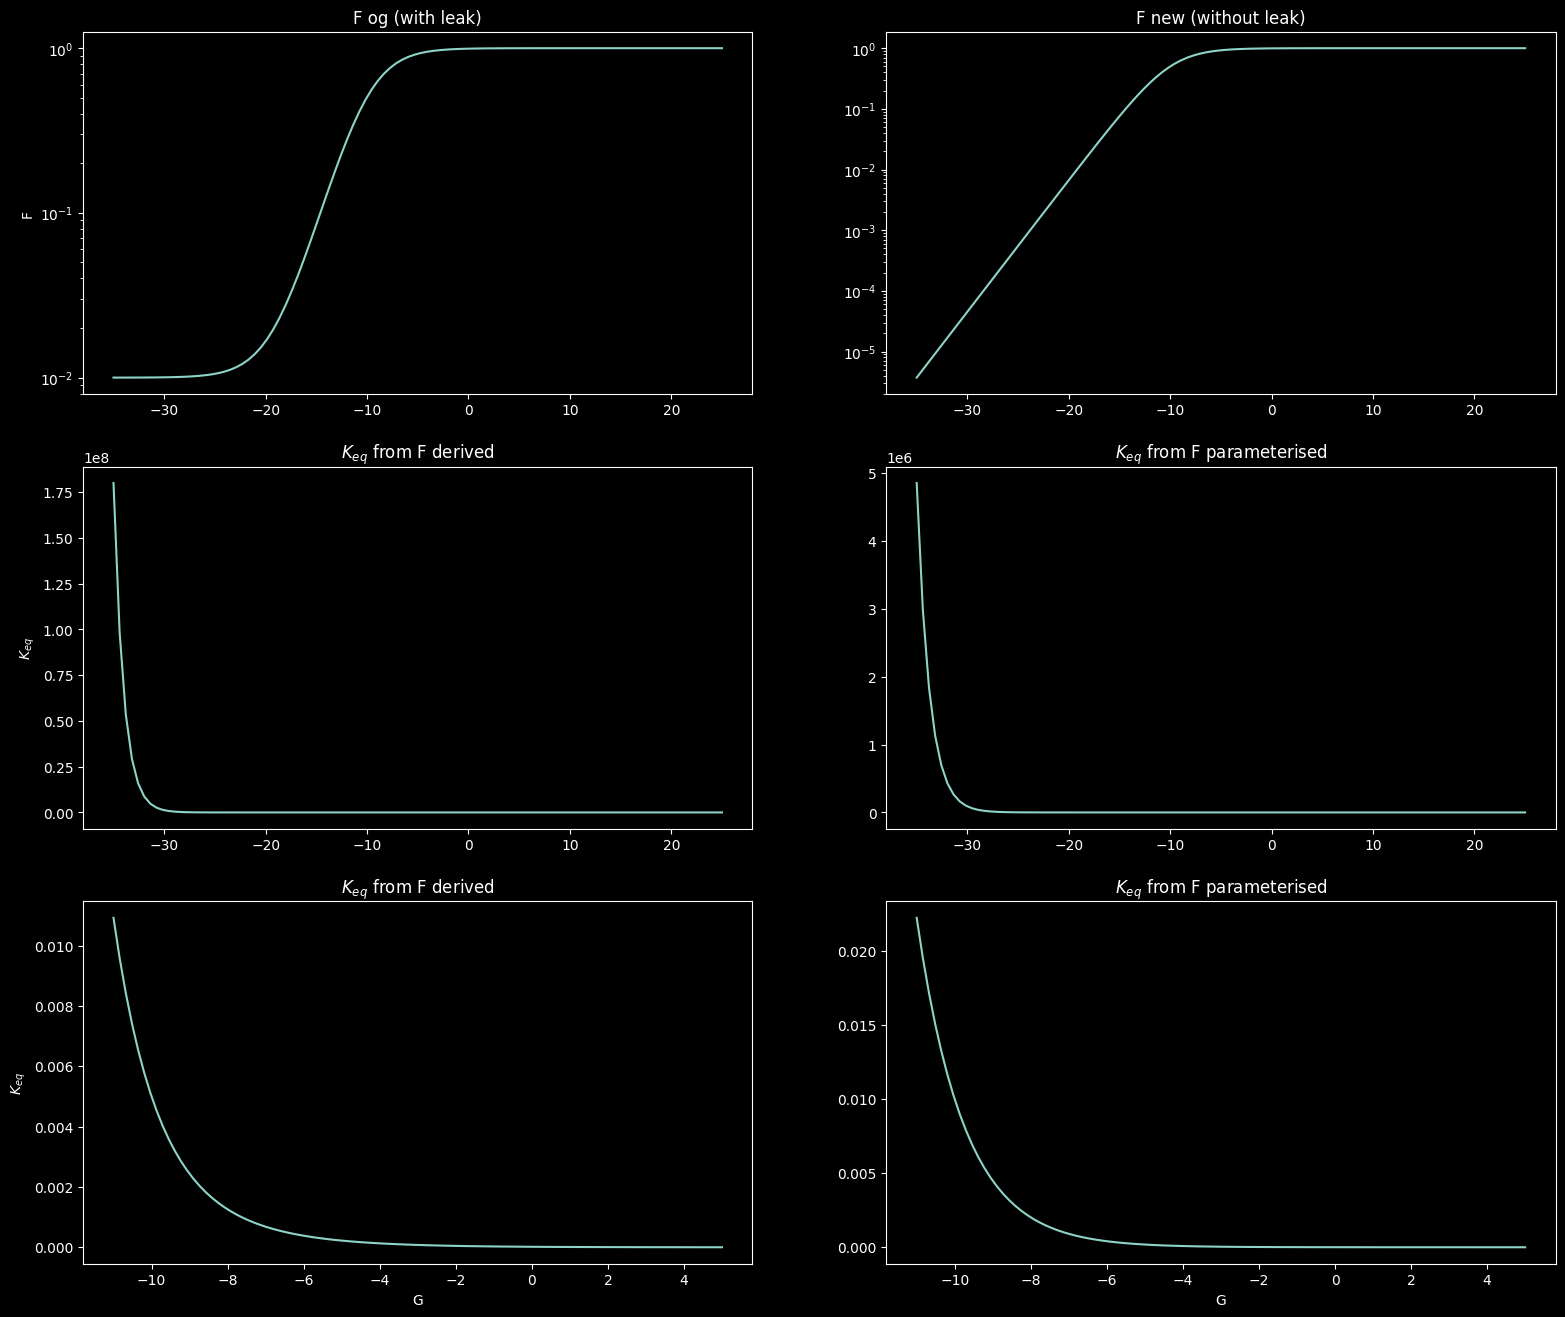

In [4]:
def F_og(E):
    """ kcal/mol """
    a = -0.5
    b = 10
    leak = 0.01
    Fs = np.exp(a * (E + b))
    return (1 - leak) / (1 + Fs) + leak


def F2(G):
    """ Does not have leakiness - bottoms out at 0 """
    alpha = -0.5
    B = 10
    Fs = np.exp(alpha * (G + B))
    return 1 / (1 + Fs)

def F3(G, m0):
    alpha = -0.8
    B = 10
    Fs = np.exp(alpha * (G + B))
    # return Fs / (Fs + 1)
    return Fs


def equilibrium_constant_fluorescence(G, initial):
    """ The input G is Gibbs free energy \Delta G in kcal/mol """
    return 1/initial * F3(G, initial)


def Kr(r1, m1, n):
    """ From r = x1 / m0 """
    return np.divide(
        1 - r1,
        np.power(r1, 2) * m1 * (1+n)
    )


Gs = np.linspace(-35, 25, 100)
initial = 100
n = 3

plt.figure(figsize=(19, 16))
ax = plt.subplot(3,2,1)
plt.plot(Gs, F_og(Gs))
plt.title('F og (with leak)')
plt.yscale('log')
plt.ylabel('F')
ax = plt.subplot(3,2,2)
plt.plot(Gs, F2(Gs))
plt.title('F new (without leak)')
plt.yscale('log')
# plt.yscale('log')
ax = plt.subplot(3,2,3)
plt.title('$K_{eq}$ from F derived')
plt.plot(Gs, Kr(F2(Gs), m1=initial, n=n))
plt.ylabel('$K_{eq}$')
# plt.yscale('log')
ax = plt.subplot(3,2,4)
plt.title('$K_{eq}$ from F parameterised')
plt.plot(Gs, equilibrium_constant_fluorescence(Gs, initial=initial))
# plt.yscale('log')

ax = plt.subplot(3,2,5)
Gs = np.linspace(-11, 5, 100)
plt.title('$K_{eq}$ from F derived')
plt.plot(Gs, Kr(F2(Gs), m1=initial, n=n))
plt.ylabel('$K_{eq}$')
plt.xlabel('G')
ax = plt.subplot(3,2,6)
plt.title('$K_{eq}$ from F parameterised')
plt.plot(Gs, equilibrium_constant_fluorescence(Gs, initial=initial))
plt.xlabel('G')

print('The K_eq at which the fluorescence, or the ratio of the unbound to the total RNA, is 0.5 is at')
print('K_eq =', Kr(F2(Gs), m1=initial, n=n)[np.argmax(F2(Gs) >= 0.5)])


Comparing the derived and parameterised approaches for a system where n = 3.

Derived

K =  [1.69583673e-05 1.69583673e-05 1.69583673e-05 1.69583673e-05
 1.69583673e-05 1.69583673e-05]
kd =  [89.01682404 89.01682404 89.01682404 89.01682404 89.01682404 89.01682404]
dt =  0.0011233831477708742
expected m =  [99.66311402 99.66311402 99.66311402 99.66311402 99.66311402 99.66311402]
simulate m =  99.66311401876014
expected ms =  [0.16844299 0.16844299 0.16844299 0.16844299 0.16844299 0.16844299]
simulate ms =  0.1684429906198992
Parameterised

K =  [3.35462628e-06 3.35462628e-06 3.35462628e-06 3.35462628e-06
 3.35462628e-06 3.35462628e-06]
kd =  [449.99945581 449.99945581 449.99945581 449.99945581 449.99945581
 449.99945581]
dt =  0.00022222249095941375
expected m =  [99.93299735 99.93299735 99.93299735 99.93299735 99.93299735 99.93299735]
simulate m =  99.93299735183706
expected ms =  [0.03350132 0.03350132 0.03350132 0.03350132 0.03350132 0.03350132]
simulate ms =  0.03350132408150061


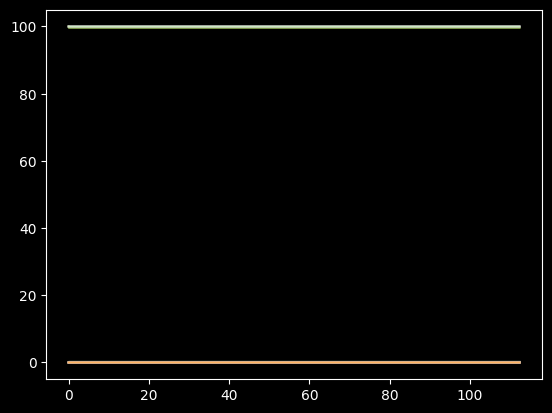

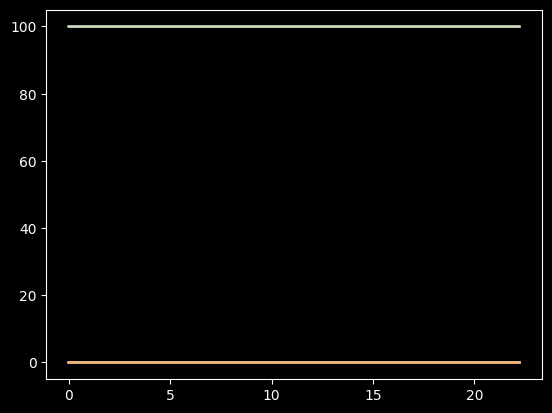

In [5]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = np.prod(
        np.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = np.prod(
        np.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def x_expected_steady_state(K, m0):
    return np.sqrt(m0/(2*K) + 1/(16*K*K)) - 1/(4*K)


Gs = np.ones(6) * 0
m0 = 100
n = 3
K1 = Kr(F2(Gs), m0, n)
K1b = Kr(F2(Gs), m0, n=2)
K2 = equilibrium_constant_fluorescence(Gs, m0)

forward_rates = np.array([0.00150958, 0.00150958, 0.00150958, 0.00150958, 0.00150958,
       0.00150958])
inputs = np.array([[0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2.]])
outputs = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

spec_conc = np.concatenate([np.zeros(6), np.ones(3) * m0])


def run_sim(K):
    reverse_rates = forward_rates / K
    
    ts = np.arange(100000)
    dt = 0.1 / np.max([np.max(forward_rates), np.max(reverse_rates)])
    all_spec_conc = np.zeros((len(ts), len(spec_conc)))
    all_spec_conc[0] = spec_conc
    for t in ts[:-1]:
        all_spec_conc[t+1] = all_spec_conc[t] + one_step_de_sim_expanded(all_spec_conc[t], inputs[[0]], outputs[[0]], forward_rates[[0]], reverse_rates[[0]]) * dt

    plt.figure()
    plt.plot(ts*dt, all_spec_conc)
    
    print('\nK = ', K)
    print('kd = ', reverse_rates)
    print('dt = ', dt)
    print('expected m = ', x_expected_steady_state(K, m0))
    print('simulate m = ', all_spec_conc[-1, 6])
    print('expected ms = ', K * np.power(x_expected_steady_state(K, m0), 2))
    print('simulate ms = ', all_spec_conc[-1, 0])
    
    return all_spec_conc

print('Derived')
all_spec_conc1 = run_sim(K1)
print('Parameterised')
all_spec_conc2 = run_sim(K2)

The derived and parameterised circuit have very small differences for the circuit where nothing should be happening, ie where the binding energies between all species are 0 kcal, showing that the parameterised equilibrium constants match the ideal reality as well.

## Justification for using parameterisation of $K_{eq}$ over derived version

The assumptions underlying the equilibrium constant derived from the steady states of unbound species and their initial quantities include
1. The equilibrium constant is the same for all species binding
2. All unbound species start from the same quantity

This makes the system similar to that where only two unbound species are binding, which is what is derived by the Gibbs free energy calculations of the RNA simulators. However, the initial quantity cannot be derived correctly from the unboudn species' steady state unless all species are considered, making it incompatible with the system considered by the minimum free binding energy simulation. The equilibrium constant at which the relative fluorescence (or the fraction of unbound to total RNA) reaches 0.5 is very low, at ca. $K_{eq} = 0.004$. This is with the initial quantity $m_i = 100$ and the number of species $ n = 3$. 



Text(0.5, 0, 'G')

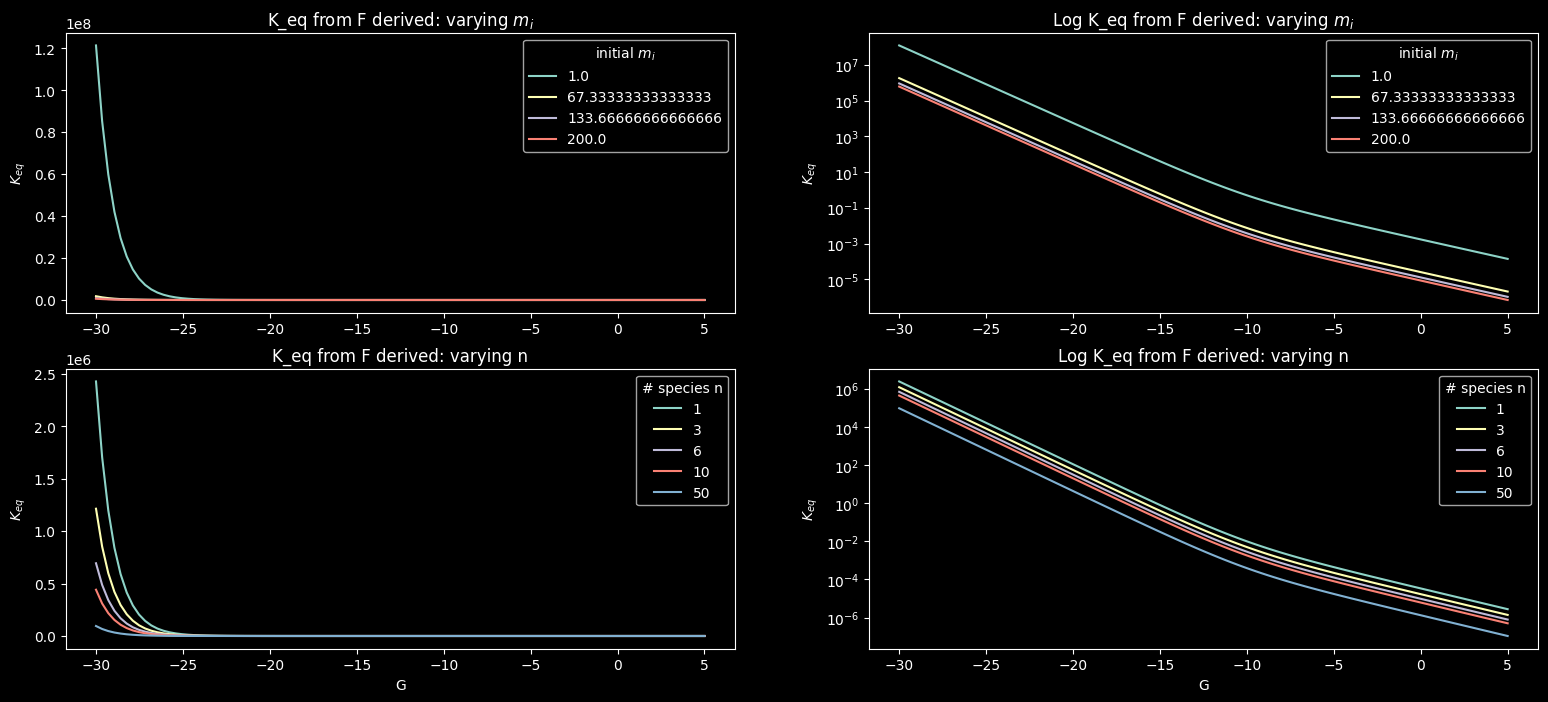

In [6]:


Gs = np.expand_dims(np.linspace(-30, 5, 100), axis=1)
ns = np.array([ 1,  3,  6, 10, 50])
ns_e = np.expand_dims(ns, axis=0)
mi = 100
m0 = np.expand_dims(np.linspace(1, 200, 4), axis=0)

plt.figure(figsize=(19, 8))
ax = plt.subplot(2,2,1)
plt.title('K_eq from F derived: varying $m_i$')
plt.plot(Gs, Kr(F2(Gs), m1=m0, n=n))
# plt.legend(ns, title='# species n')
plt.legend(m0[0], title='initial $m_i$')
plt.ylabel('$K_{eq}$')
ax = plt.subplot(2,2,2)
plt.title('Log K_eq from F derived: varying $m_i$')
plt.plot(Gs, Kr(F2(Gs), m1=m0, n=n))
# plt.legend(ns, title='# species n')
plt.legend(m0[0], title='initial $m_i$')
plt.ylabel('$K_{eq}$')
plt.yscale('log')

ax = plt.subplot(2,2,3)
plt.title('K_eq from F derived: varying n')
plt.plot(Gs, Kr(F2(Gs), m1=mi, n=ns_e))
plt.legend(ns, title='# species n')
plt.ylabel('$K_{eq}$')
plt.xlabel('G')
ax = plt.subplot(2,2,4)
plt.title('Log K_eq from F derived: varying n')
plt.plot(Gs, Kr(F2(Gs), m1=mi, n=ns_e))
plt.legend(ns, title='# species n')
plt.ylabel('$K_{eq}$')
plt.yscale('log')
plt.xlabel('G')

The dependence of the derived equations on $n$ and $m_i$ (initial quantity for species i).

Text(0, 0.5, '# molecules')

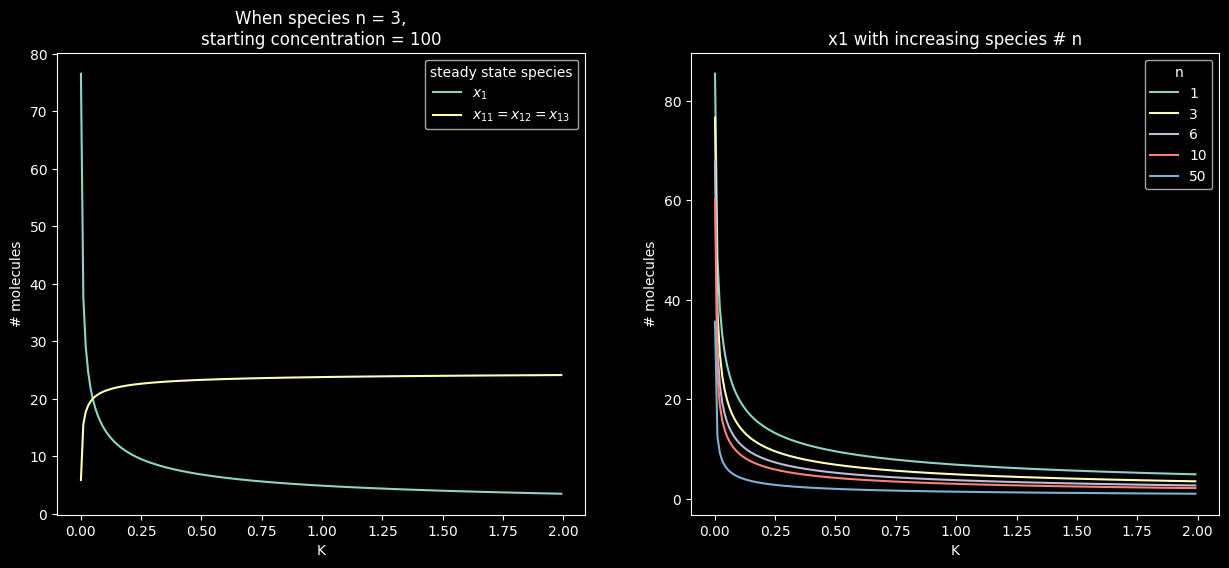

In [7]:
def x1_n(K, m1, n):
    return np.divide(
        -1 + np.sqrt( 1 + 4*K*m1*(1+n)),
        2*K*(1+n)
    )

def x11_n(K, m1, n):
    return K * np.power(x1_n(K, m1, n), 2)

plt.figure(figsize=(15,6))

ax = plt.subplot(1,2,1)
K = np.expand_dims(np.arange(0.001, 2, 0.01), axis=1)
m1 = 100
plt.plot(K, x1_n(K, m1=m1, n=3))
plt.plot(K, x11_n(K, m1=m1, n=3))
plt.title(f'When species n = 3,\nstarting concentration = {m1}')
plt.xlabel('K')
plt.ylabel('# molecules')
plt.legend(['$x_1$', '$x_{11} = x_{12} = x_{13}$'], title='steady state species')

ax = plt.subplot(1,2,2)
ns = np.array([1, 3, 6, 10, 50])
n = 3
plt.plot(K, x1_n(K, m1=m1, n=np.expand_dims(ns, axis=0)))
plt.legend(ns, title='n')
plt.title('x1 with increasing species # n')
plt.xlabel('K')
plt.ylabel('# molecules')


/tmp/ipykernel_573264/4084530681.py:27: RuntimeWarning: divide by zero encountered in divide
  return np.divide(


Text(0, 0.5, 'K')

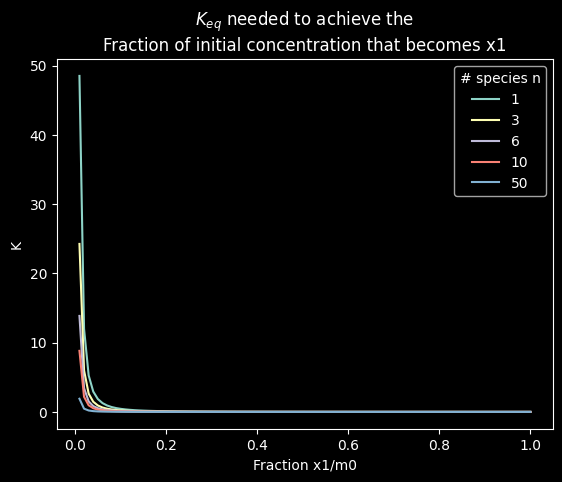

In [8]:
def r1_incomplete(K, m1, n):
    """ x1 / x11 """
    return np.divide(
        2*(1+n),
        -1 + np.sqrt(1+4*K*m1*(1+n))
    )


def Kr_incomplete(r1, m1, n):
    """ from r = x1 / x11"""
    return np.divide(
        1 + n + r1,
        m1 * np.power(r1, 2)
    )


def r1(K, m1, n):
    """ Assuming all ka and kd are equal
    x1 / m0 = x1 / (x1 + (1+n) * x11) """
    return np.divide(
        2,
        1 + np.sqrt(1 + 4*K*m1*(1+n))
    )

def Kr(r1, m1, n):
    """ from r = x1 / m0 """
    return np.divide(
        1 - r1,
        np.power(r1, 2) * m1 * (1+n)
    )

rs = np.expand_dims(np.linspace(0, 1, 100), axis=1)
m0 = 100
plt.plot(rs, Kr(r1=rs, m1=m0, n=np.expand_dims(ns, axis=0)))
plt.legend(ns, title='# species n')
plt.title('$K_{eq}$ needed to achieve the \nFraction of initial concentration that becomes x1')
plt.xlabel('Fraction x1/m0')
plt.ylabel('K')


# Further old derivations: Initial attempts at reparameterisation

Here is the first attempt at relaying the relative fluorescence to the equilibrium constant. The main flaw in this approach was that there is a quadratic relationship between the unbound and bound species that was not accounted for properly, leading to equilibrium constants that are too large. Systems where no binding should be occuring because the binding energy is $0 kcal$ were showing a lot of binding instead.

We have previously derived an approximation for this in the following manner, where $F = $ fluorescence, $D = $ free DNA, $S = $ sRNA, $SD = $ bound DNA, $k_a = $ association rate, $k_d = $ dissociation rate, and $K = $ equilibrium constant:

$$F = \frac{[D]}{([D] + [SD])} $$
$$\frac{1}{F} - 1 = \frac{[SD]}{[D]}$$

We already know the equilibrium constant from $\Delta G$:

$$K = e^{- \Delta G / RT} = \frac{k_a}{k_d} = \frac{[Product]}{[Reactants]} = \frac{[SD]}{[S][D]}$$

We also know that for different fluorescences, different forward and reverse rates must be in play.

$$F = 1 \to k_d >> k_a $$
$$F = 0.001 \to k_d << k_a $$
$$F = 0.5 \to [D] = [SD] \to \frac{k_a}{k_d} = \frac{[SD]}{[S][D]} \approx \frac{1}{[S]} $$
$$F = 0.25 \to [D] = 3[SD] \to \frac{k_a}{k_d} = \frac{3[SD]}{[S][D]} \approx \frac{3}{[S]} $$

$$\frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1}{F} - 1 \big) $$

In the code above, we have fit a sigmoid curve to the data in the research paper. This fit curve gives

$$F(\Delta G) \approx \frac{1 - 0.01}{1 + e^{-(\Delta G / 2 + 5)}} + 0.01 $$

If we expand this out and make fluorescence dependent on the minimum free energy of binding $\Delta G$:

$$K = \frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1 - 0.01}{\frac{1}{1 + e^{-(\Delta G / 2 + 5)}} + 0.01} - 1 \big) $$

Since we have also estimated a constant value for association constant $k_a$, this would be used to find the dissociation constant. The only question is what to do with the S term in the final equation. Since we know that at half the normalised fluorescence $F = 0.5$, the equilibrium constant should be equal to 1 ($K = 1$), as the ratio of bound to unbound species should be 1. From this, we can find the concentration $[S]$ that fulfills the equation.


Text(0.5, 1.0, 'k_d, [S] = 0.98mol')

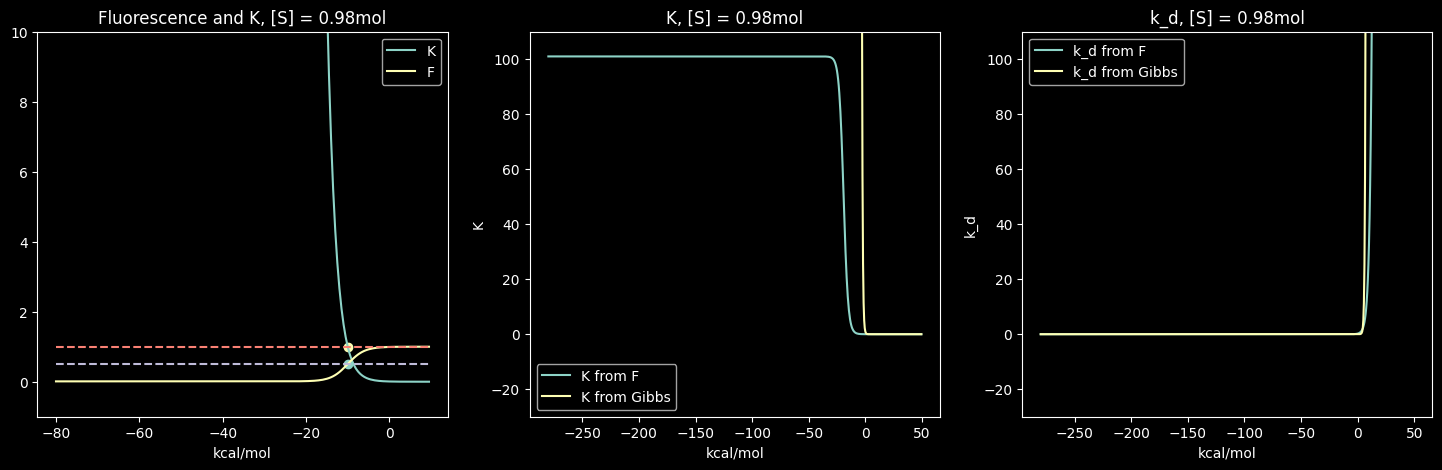

In [9]:
def F(E):
    """ kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F


def gibbs_K_cal(E):
    """ In kcal/mol. dG = - RT ln(K) """
    RT = 1.987 * 310
    E = E * 1000
    K = np.exp(-E/(RT))
    return K


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return 1/initial * (1/F(E) - 1)


E = np.arange(-80, 10, 0.5)
E_F_half = E[np.argmax(F(E) >= 0.5)]
initial = np.round(1/1 * (1/F(E_F_half) - 1), 2)
k_a = 0.0015


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(
    E,
    equilibrium_constant_fluorescence(E, initial),
    label='K'
)
plt.xlabel('kcal/mol')
plt.plot(
    E,
    F(E),
    label='F'
)
plt.scatter(E_F_half, F(E_F_half))
plt.scatter(E_F_half, equilibrium_constant_fluorescence(E_F_half, initial))
plt.plot(E, np.ones_like(E) * F(E_F_half), '--')
plt.plot(E, np.ones_like(E) * equilibrium_constant_fluorescence(E_F_half, initial), '--')
plt.ylim(-1, 10)
plt.legend()
plt.title(f'Fluorescence and K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 2)
E2 = np.arange(-280, 50, 0.5)
plt.plot(E2, equilibrium_constant_fluorescence(E2, initial), label='K from F')
plt.plot(E2, gibbs_K_cal(E2), label='K from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.ylim(-30, 110)
plt.title(f'K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 3)
plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, initial), label='k_d from F')
plt.plot(E2, k_a/gibbs_K_cal(E2), label='k_d from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.ylim(-30, 110)
plt.title(f'k_d, [S] = {initial}mol')




In this case, $[S]$ turned out to be roughly equal to 1 mol for the $\Delta G$ where F = 0.5 the same as that for making $K = 1$, which turned out to be roughly around $\Delta G = - 10$ kcal/mol.
For comparison, the original equation for K and $\Delta G$ is plotted as well and shows a much faster increase past 1, around -1 kcal/mol.

Text(0.5, 1.0, 'k_d from Gibbs, k_a = 0.0015')

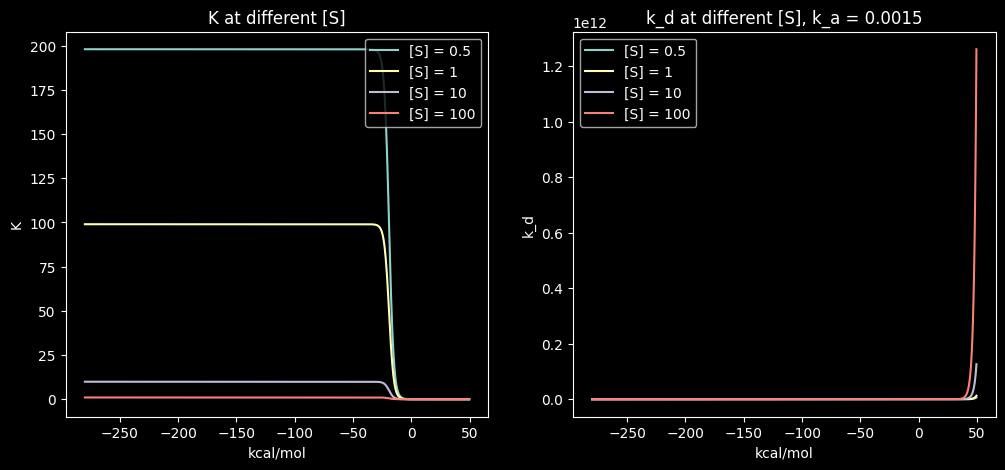

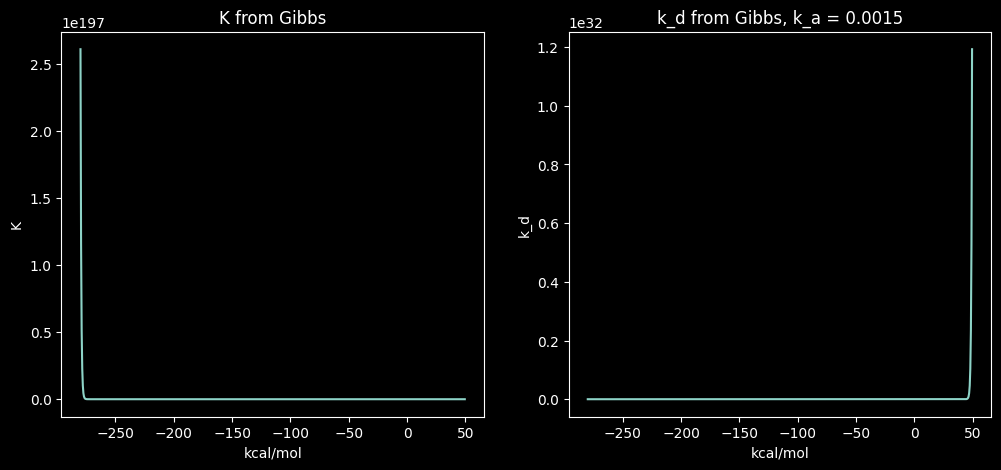

In [10]:
S = [0.5, 1, 10, 100]

plt.figure(figsize=(12, 5))
for s in S:
    ax = plt.subplot(1,2,1)
    plt.plot(E2, equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')
    ax = plt.subplot(1,2,2)
    plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')

ax = plt.subplot(1,2,1)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K at different [S]')

ax = plt.subplot(1,2,2)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d at different [S], k_a = {k_a}')


# Comparison to Gibbs
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.plot(E2, gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K from Gibbs')

ax = plt.subplot(1,2,2)
plt.plot(E2, k_a/gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d from Gibbs, k_a = {k_a}')



In [11]:
K_G = gibbs_K_cal(E2)
K_F = equilibrium_constant_fluorescence(E2, initial)
print('dG at which K from Gibbs is 1:\t\t\t', E2[np.argmax(K_G <= 1)])
print('dG at which K from Fluorescence is 1:\t\t',E2[np.argmax(K_F <= 1)])

print('K from Gibbs at -100 kcal:\t\t\t', gibbs_K_cal(-100))
print('K from Fluorescence at -100 kcal:\t\t\t', equilibrium_constant_fluorescence(-100, initial))


dG at which K from Gibbs is 1:			 0.0
dG at which K from Fluorescence is 1:		 -9.5
K from Gibbs at -100 kcal:			 3.204680085638281e+70
K from Fluorescence at -100 kcal:			 101.0204081632653


From above calculations, the $\Delta G$ at which K is equal to 1 is $\Delta G = 0 $ kcal for K derived from the Gibbs equation, while for the K derived from the fitted fluorescence curve it is $\Delta G \approx -10 $ kcal. It now takes a more negative $\Delta G$ for the equilibrium constant to reach a balance between forward and reverse reaction rates. This means that circuit components must interact much more strongly to be considered binding.

At the same time, the K derived from fluorescence increases more quickly once it is past the $K = 1$, meaning that as soon as any RNA is binding strongly enough, it will bind much more strongly that from the Gibbs free energy case. Therefore, the new energy approximation curve will be biased against RNAs that bind in the intermediate range.

### Exploring 

Some values from simulations, where m is an unbound species and ms is a bound species:

/tmp/ipykernel_573264/1435608552.py:14: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(np.log(mbar(K, m0) / msbar(K, m0)), cmap=sns.color_palette("icefire", as_cmap=True))


Text(0, 0.5, '# molecules')

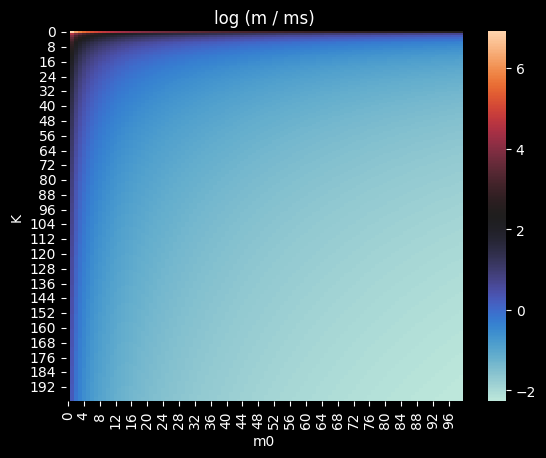

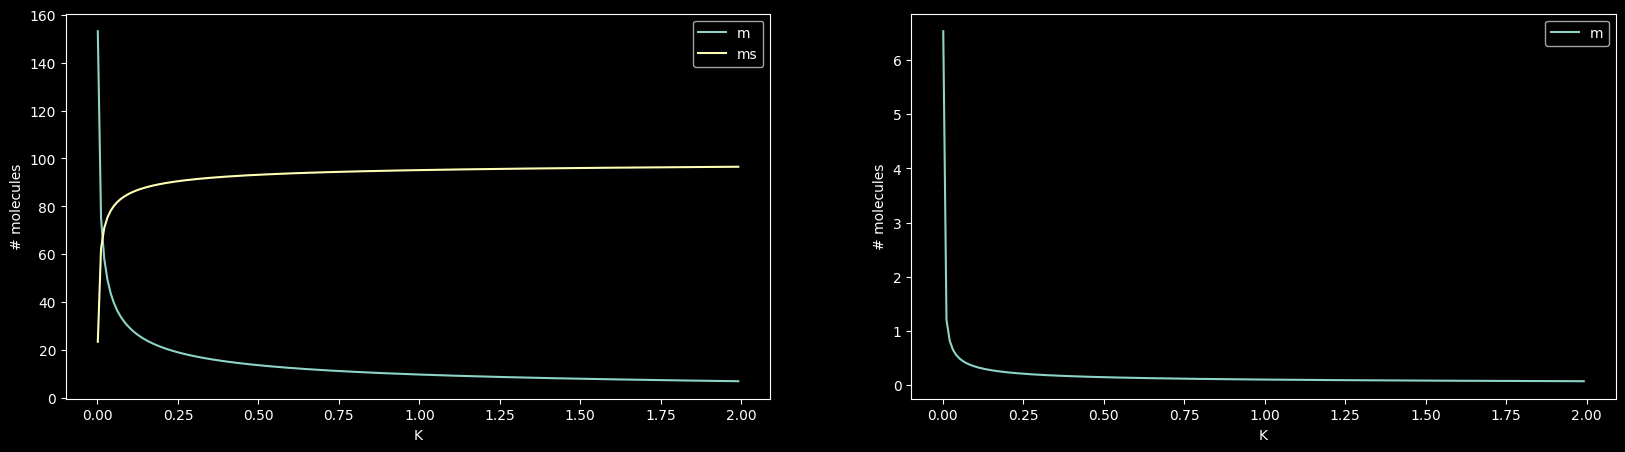

In [12]:
m0 = np.arange(100)
K = np.expand_dims(np.arange(0.001, 2, 0.01), axis=1)

def mbar(K, m0):
    return np.divide((-1 + np.sqrt(1 + 8*K*m0)), 4*K)


def m(K, m0):
    return np.sqrt(m0/(2*K) + 1/(16*K*K)) - 1/(4*K)

def msbar(K, m0):
    return K * np.power(mbar(K, m0), 2)

sns.heatmap(np.log(mbar(K, m0) / msbar(K, m0)), cmap=sns.color_palette("icefire", as_cmap=True))
plt.xlabel('m0')
plt.ylabel('K')
plt.title('log (m / ms)')

m00 = 200
plt.figure(figsize=(20, 5))
ax = plt.subplot(1,2,1)
plt.plot(K, mbar(K, m00))
plt.plot(K, msbar(K, m00))
plt.legend(['m', 'ms'])
plt.xlabel('K')
plt.ylabel('# molecules')

ax = plt.subplot(1,2,2)
plt.plot(K, mbar(K, m00) / msbar(K, m00))
plt.legend(['m', 'ms'])
plt.xlabel('K')
plt.ylabel('# molecules')

Including n species:

Text(0, 0.5, '# molecules')

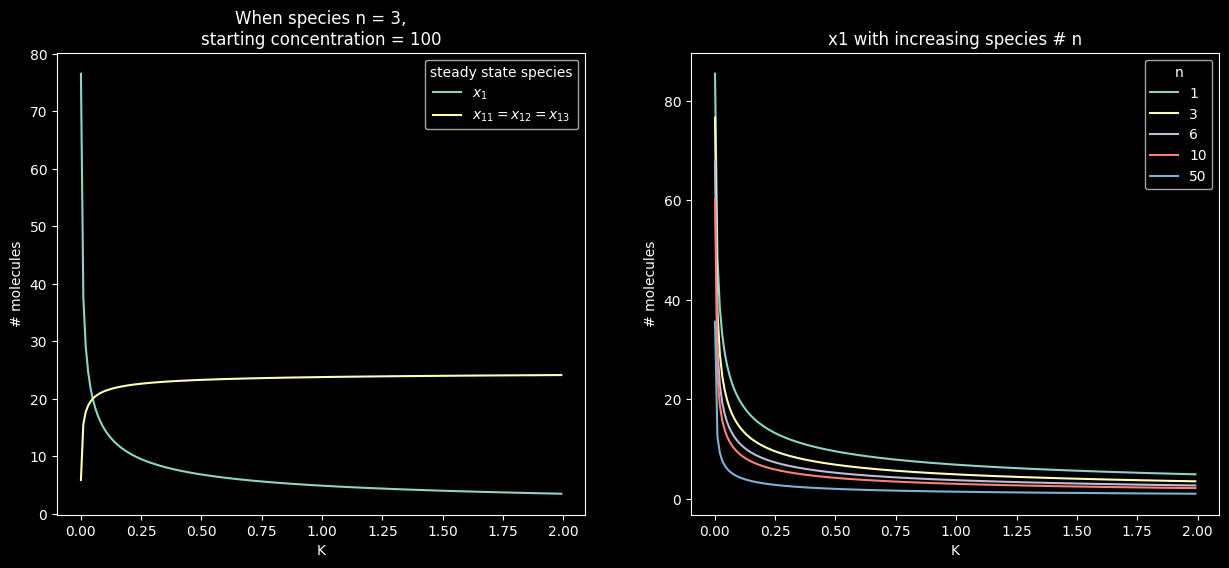

In [13]:
def x1_n(K, m1, n):
    return np.divide(
        -1 + np.sqrt( 1 + 4*K*m1*(1+n)),
        2*K*(1+n)
    )

def x11_n(K, m1, n):
    return K * np.power(x1_n(K, m1, n), 2)

plt.figure(figsize=(15,6))

ax = plt.subplot(1,2,1)
K = np.expand_dims(np.arange(0.001, 2, 0.01), axis=1)
m1 = 100
plt.plot(K, x1_n(K, m1=m1, n=3))
plt.plot(K, x11_n(K, m1=m1, n=3))
plt.title(f'When species n = 3,\nstarting concentration = {m1}')
plt.xlabel('K')
plt.ylabel('# molecules')
plt.legend(['$x_1$', '$x_{11} = x_{12} = x_{13}$'], title='steady state species')

ax = plt.subplot(1,2,2)
ns = np.array([1, 3, 6, 10, 50])
plt.plot(K, x1_n(K, m1=m1, n=np.expand_dims(ns, axis=0)))
plt.legend(ns, title='n')
plt.title('x1 with increasing species # n')
plt.xlabel('K')
plt.ylabel('# molecules')


K =  0.0066701183
expected m =  69.84478984300942
simulate m =  69.84482
expected ms =  32.53880253924764
simulate ms =  32.538788

Fraction m:  0.6821875
Fraction ms:  0.31781247

Fraction m full:  0.34922415
Fraction ms full:  0.16269396


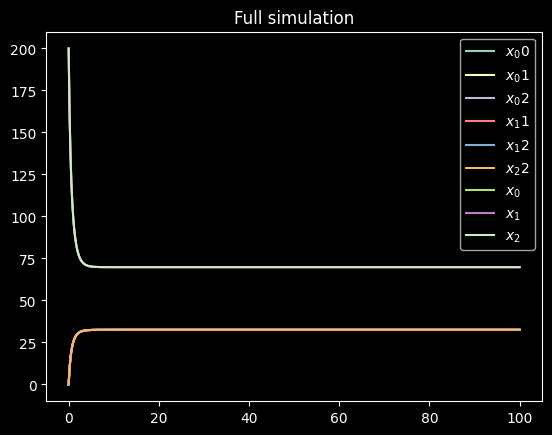

In [14]:
K = 0.0066701183
reverse_rates = forward_rates / K


def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates)


d_term = dfx.ODETerm(
    partial(bioreaction_sim_expanded,
            inputs=inputs, outputs=outputs,
            forward_rates=forward_rates, reverse_rates=reverse_rates
            )
)

def flatten_list(l):
    return [item for sublist in l for item in sublist] 


m0 = 200
n = 3

# ms = 32.5388
# m = 69.84483
spec_conc = np.concatenate([np.zeros(6), np.ones(3) * m0])
species_names = flatten_list([[f'$x_{str(i)+str(j)}$' for j in range(i, 3)] for i in range(3)]) + [f'$x_{i}$' for i in range(3)]
v = dfx.diffeqsolve(d_term, solver=dfx.Tsit5(), t0=0, t1=100,
                    dt0=0.1, y0=spec_conc, saveat=dfx.SaveAt(t0=True, t1=True, steps=True))
x = v.ys[:v.stats['num_accepted_steps']]


print('K = ', K)
print('expected m = ', x1_n(K, m1=m0, n=n))
print('simulate m = ', x[-1, 6])
print('expected ms = ', x11_n(K, m1=m0, n=n))
print('simulate ms = ', x[-1, 0])

print('\nFraction m: ', x[-1, 6] / (x[-1, 6] + x[-1, 0]))
print('Fraction ms: ', x[-1, 0] / (x[-1, 6] + x[-1, 0]))
print('\nFraction m full: ', x[-1, 6] / (x[-1, 6] + (1+n)*x[-1, 0]))
print('Fraction ms full: ', x[-1, 0] / (x[-1, 6] + (1+n)*x[-1, 0]))

plt.plot(v.ts, v.ys)
plt.title('Full simulation')
plt.legend(species_names)


/tmp/ipykernel_573264/3263480831.py:27: RuntimeWarning: divide by zero encountered in divide
  return np.divide(


Text(0, 0.5, 'K')

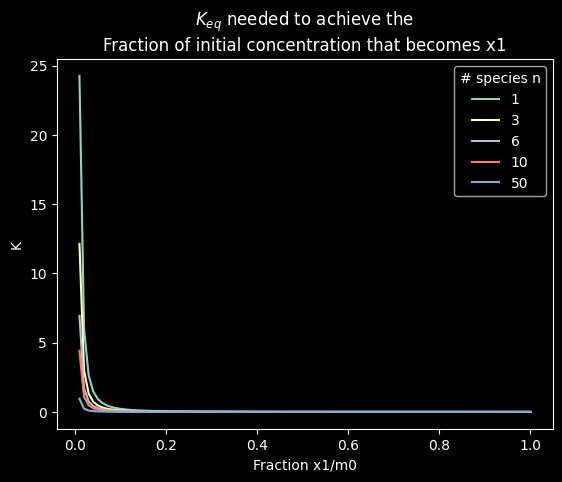

In [15]:
def r1_incomplete(K, m1, n):
    """ x1 / x11 """
    return np.divide(
        2*(1+n),
        -1 + np.sqrt(1+4*K*m1*(1+n))
    )


def Kr_incomplete(r1, m1, n):
    """ from r = x1 / x11"""
    return np.divide(
        1 + n + r1,
        m1 * np.power(r1, 2)
    )


def r1(K, m1, n):
    """ Assuming all ka and kd are equal
    x1 / m0 = x1 / (x1 + (1+n) * x11) """
    return np.divide(
        2,
        1 + np.sqrt(1 + 4*K*m1*(1+n))
    )

def Kr(r1, m1, n):
    """ from r = x1 / m0 """
    return np.divide(
        1 - r1,
        np.power(r1, 2) * m1 * (1+n)
    )

rs = np.expand_dims(np.linspace(0, 1, 100), axis=1)
plt.plot(rs, Kr(r1=rs, m1=m0, n=np.expand_dims(ns, axis=0)))
plt.legend(ns, title='# species n')
plt.title('$K_{eq}$ needed to achieve the \nFraction of initial concentration that becomes x1')
plt.xlabel('Fraction x1/m0')
plt.ylabel('K')


## Tests

How does the new RNA equilibrium constant calculation change real samples? Let's look at some test circuits where we know they have weak / medium / strong binding energies and compare their dynamics between the Gibbs free energy and reparameterised equilibrium constant calculation methods.

Get outer level imports first...

In [16]:
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from copy import deepcopy
from tests_local.shared import five_circuits, CONFIG
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller

config = deepcopy(CONFIG)

Initialise circuits, then change the equilibrium constants and binding rates of dissociation to pull from the fluorescence-based approximation of binding.

In [17]:
config['simulation']

{'dt': 0.1,
 't0': 0,
 't1': 100,
 'tmax': 20000,
 'solver': 'diffrax',
 'use_batch_mutations': True,
 'interaction_factor': 1,
 'batch_size': 100,
 'max_circuits': 1000,
 'device': 'cpu',
 'threshold_steady_states': 0.001,
 'use_rate_scaling': True}

In [18]:
circuits, config, data_writer = five_circuits(
    config, data_writer=None)

config['include_prod_deg'] = False
config['simulation']['use_rate_scaling'] = False
config['molecular_params_factor'] = 1
config['simulation']['interaction_factor'] = 1
config['simulation']['t1'] = 1500
config['simulation']['dt'] = 0.01
config['simulation']['threshold_steady_states'] = 0.0001

for c in circuits:
    c.reset_to_initial_state()



experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/0_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/eqconstants/0_weak_eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/energies/0_weak_energies.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_sites/0_weak_binding_sites.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/1_med_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead

In [19]:
def init_circuits(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuit": {}
            # "simulate_signal_batch": {'ref_circuit': None,
            #                           'batch': config['simulation']['use_batch_mutations']},
            # "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
            #                   'no_numerical': config['experiment']['no_numerical']}
        })
    return circuits

In [20]:
circuits = init_circuits(circuits)

simulator.py:check_IntaRNA_path():117: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING
circuit_manager_new.py:batch_circuits():574: 	From 5 circuits, a total of 5 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():581: 		Starting new round of viable circuits (0 - 5 / 5) WARNING
circuit_manager_new.py:batch_circuits():599: 		Making subcircuits 0 - 5 took 1.9e-05s WARNING
circuit_manager_new.py:batch_circuits():605: 	Batching 0 - 100 circuits (out of 0 - 5 (total: 5)) (Circuits: 0 - 5 of 5) WARNING
circuit_manager_new.py:run_batch():636: 		Running 5 Subcircuits - 0_weak: compute_interactions WARNING


FileNotFoundError: [Errno 2] No such file or directory: 'IntaRNA'

In [ ]:


def sim_write(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            # "init_circuit": {}
            "simulate_signal_batch": {'ref_circuit': None,
                                    'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': False, # config['experiment']['no_visualisations'],
                            'no_numerical': False} #config['experiment']['no_numerical']}
        })
    return circuits



In [ ]:
circuits = sim_write(circuits)

circuit_manager_new.py:batch_circuits():574: 	From 5 circuits, a total of 5 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():581: 		Starting new round of viable circuits (0 - 5 / 5) WARNING
circuit_manager_new.py:batch_circuits():599: 		Making subcircuits 0 - 5 took 1.6e-05s WARNING
circuit_manager_new.py:batch_circuits():605: 	Batching 0 - 100 circuits (out of 0 - 5 (total: 5)) (Circuits: 0 - 5 of 5) WARNING
circuit_manager_new.py:run_batch():636: 		Running 5 Subcircuits - 0_weak: simulate_signal_batch WARNING
circuit_manager_new.py:prepare_internal_funcs():497: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager_new.py:simulate_signal_batch():345: 		Simulating signal took 9.005334s WARNING


Done:  0:00:08.987247


circuit_manager_new.py:simulate_signal_batch():403: 		Calculating analytics took 1.434113s WARNING
circuit_manager_new.py:run_batch():672: 		Method simulate_signal_batch took 10.663724s WARNING
circuit_manager_new.py:run_batch():636: 		Running 5 Subcircuits - 0_weak: write_results WARNING
circuit_manager_new.py:run_batch():672: 		Method write_results took 1.631077s WARNING
circuit_manager_new.py:batch_circuits():619: Single batch: 0:00:12.297071 
Projected time: 12.297071s 
Total time: 0:00:12.297081 WARNING


In [ ]:

def vis_sim(circuits):
    output_files = pd.concat([
        pd.read_csv(os.path.join(data_writer.write_dir, c.name, 'output_summary.csv')) for c in circuits
    ], axis=0)

    from IPython.display import SVG, display
    x = output_files[(output_files['out_type'] == 'svg') & (output_files['name'] == 'signal')]
    for out_path, subdir in zip(x['out_path'], x['subdir']):
        print(subdir)
        display(SVG(filename=out_path))

0_weak


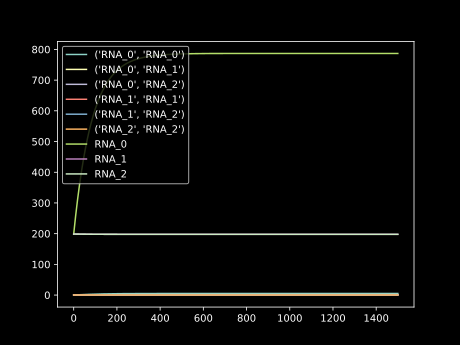

1_med_weak


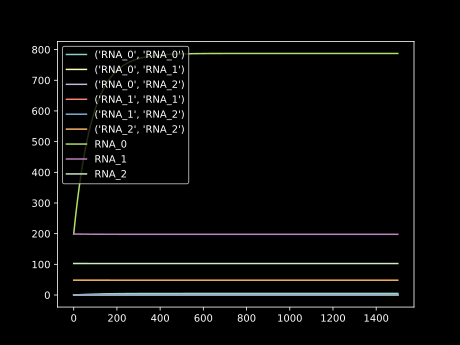

2_medium


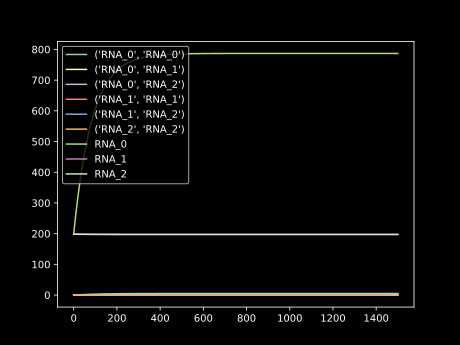

3_med_strong


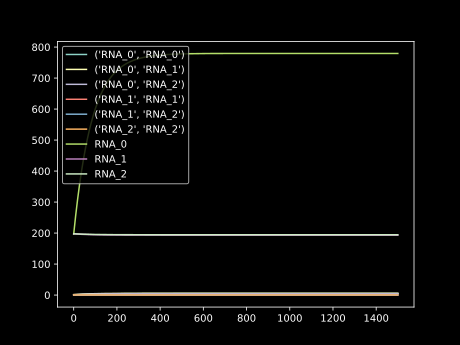

4_strong


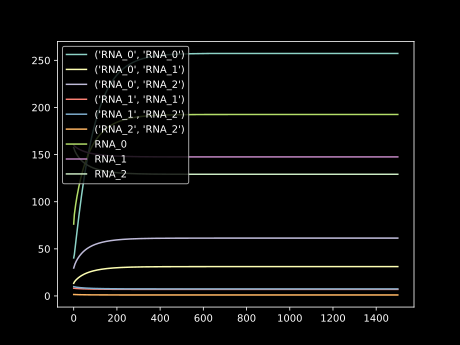

In [ ]:
vis_sim(circuits)